# Logits

To study the logits of neural network models

In [1]:
import os
import argparse
import yaml
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

import sys
sys.path.insert(0, '../')
from loaders import get_loader
from learners import get_learner
from models import get_model
from utils import trust_scores
from metrics import Metrics
import utils.logger
LOGGER = utils.logger.get_logger(__name__, level='DEBUG')

No module named 'structured_map_ranking_loss'


## Load normal model

In [138]:
# 20, 200, 490

In [146]:
config_path = '/home/docker_user/shared/ccorbiere/logs/cifar100/logits/cifar100_calibration_resnet50_lr1/config_1.yaml'
epoch = 490
mode = 'normal'
start_epoch = 1

# Dataloader
with open(config_path, 'r') as f:
    config_args = yaml.load(f, Loader=yaml.SafeLoader)
    config_args['training']['metrics'] = ['accuracy', 'auc', 'ap_success', 'ap_errors']

config_args['data']['is_test'] = True
config_args['model']['feature_dim'] = 512
   
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
LOGGER.info('Loading dataset {}'.format(config_args['data']['dataset']))
dloader = get_loader(config_args, generating=True)

# Make loaders
dloader.make_loaders()

# Set learner
LOGGER.warning('Learning type: {}'.format(config_args['training']['learner']))
learner_normal = get_learner(config_args, dloader.train_loader, dloader.val_loader, 
                             dloader.test_loader, start_epoch, device)

# Load model
# Initialize and load model
ckpt_path = os.path.join(config_args['training']['output_folder'], 'model_epoch_{:03d}.ckpt'.format(epoch))
checkpoint = torch.load(ckpt_path)
learner_normal.model.load_state_dict(checkpoint['model_state_dict'])

# Get scores
LOGGER.info('Inference mode: {}'.format(mode))

if not hasattr(checkpoint, 'prod_test_len'):
    learner_normal.prod_test_len = learner_normal.nsamples_test

2019-07-24 16:32:50,521 mustang __main__[39157] INFO Loading dataset cifar100
2019-07-24 16:32:50,523 mustang loaders.loader[39157] INFO --- Augmentations ---
2019-07-24 16:32:50,523 mustang augmentations[39157] INFO Using hflip aug with params True
2019-07-24 16:32:50,524 mustang augmentations[39157] INFO Using random_crop aug with params 32
2019-07-24 16:32:50,525 mustang augmentations[39157] INFO Using No Augmentations


Files already downloaded and verified
Files already downloaded and verified


2019-07-24 16:32:55,500 mustang loaders.loader[39157] WARNING Loading existing train-val split indices
2019-07-24 16:32:55,514 mustang __main__[39157] WARNING Learning type: default
2019-07-24 16:32:56,504 mustang learners.learner[39157] INFO Using optimizer sgd
2019-07-24 16:32:56,883 mustang __main__[39157] INFO Inference mode: normal


## Compute predictions

In [147]:
def predict_model(test_loader, model):
    accuracy = 0
    accurate, proba_pred = [], []
    alpha_0, max_alpha, u1, entropy, logits = [], [], [], [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(test_loader)
        for j, (data,target) in enumerate(loop):
            data, target = data.to(device), target.to(device)
            output = learner_normal.model(data)
            if isinstance(output,tuple):
                output = output[0]
            alpha_0.extend(output.sum(dim=1))
            max_alpha.extend(output.max(dim=1)[0])
            u1.extend((output.max(dim=1, keepdim=True)[0]-output).mean(dim=1))
            logits.extend(output)
            proba = F.softmax(output, dim=1)
            entropy.extend((-proba*torch.log(proba)).sum(dim=1))
            confidence, pred = proba.max(dim=1, keepdim=True)
            accuracy += pred.eq(target.view_as(pred)).sum()
            accurate.extend(pred.eq(target.view_as(pred)))
            proba_pred.extend(confidence)

    alpha_0 = torch.stack(alpha_0).detach().to('cpu')
    max_alpha = torch.stack(max_alpha).detach().to('cpu')
    u1 = torch.stack(u1).detach().to('cpu')
    entropy = torch.stack(entropy).detach().to('cpu')
    logits = torch.stack(logits).detach().to('cpu')
    
    proba_pred = torch.stack(proba_pred).detach().to('cpu') #.numpy()   
    accurate = torch.cat(accurate).detach().to('cpu') #.numpy()

    len_test_set = len(dloader.test_loader.dataset)
    accuracy = accuracy.item() / float(len_test_set)
    print('Test set: Accuracy: {}/{} ({:.2f}%)'.format(
        int(accuracy*len_test_set), len_test_set, 100*accuracy))
    
    return proba_pred, accurate, accuracy, alpha_0, max_alpha, u1, entropy, logits

In [148]:
proba_pred_normal, accurate_normal, accuracy_normal, alpha_0, max_alpha, u1, entropy, logits = predict_model(dloader.test_loader, learner_normal.model)


Test set: Accuracy: 7453/10000 (74.53%)


In [149]:
other_logits = ((logits != max_alpha.unsqueeze(1)).float()*logits)

In [139]:
maxz, logitz, other_logitz, alpha_0z = [], [], [], []

In [150]:
maxz.append(max_alpha[idx].numpy())
logitz.append(logits[idx].flatten().numpy())
other_logitz.append(other_logits[idx].flatten().numpy())
alpha_0z.append(alpha_0[idx].flatten().numpy())

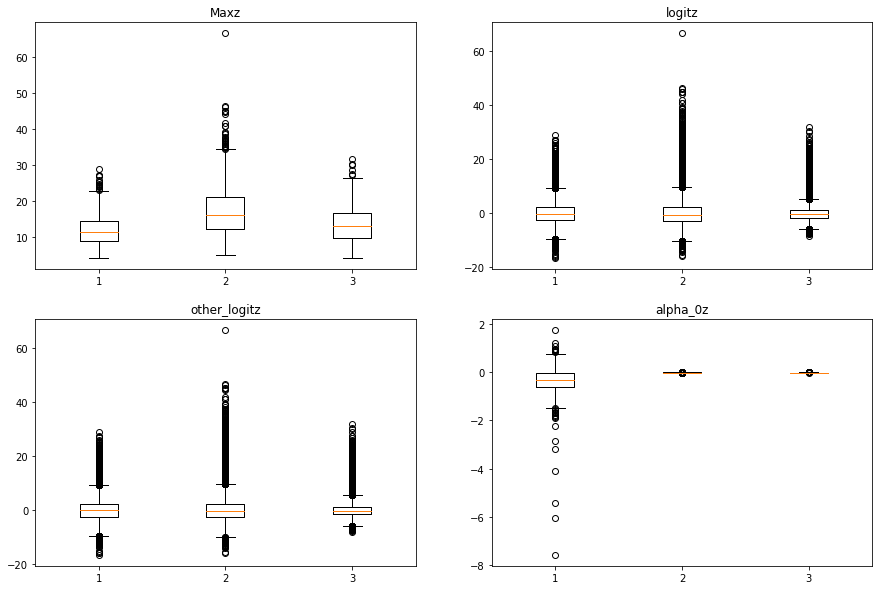

In [151]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title('Maxz')
plt.boxplot(maxz)
plt.subplot(222)
plt.title('logitz')
plt.boxplot(logitz)
plt.subplot(223)
plt.title('other_logitz')
plt.boxplot(logitz)
plt.subplot(224)
plt.title('alpha_0z')
plt.boxplot(alpha_0z)
plt.show()

In [107]:
k = 1000
perm = torch.randperm(logits.size(0))
idx = perm[:k]

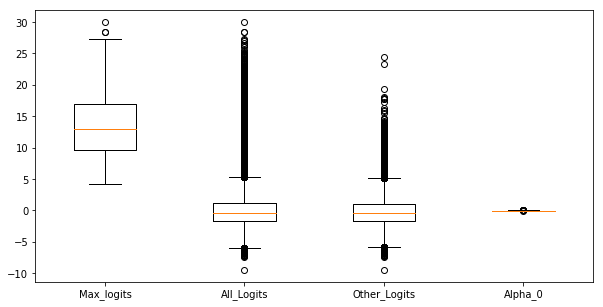

In [88]:
plt.figure(figsize=(10,5))
plt.boxplot([max_alpha[idx], logits[idx].flatten().numpy(), other_logits[idx].flatten().numpy(), alpha_0[idx]], labels=['Max_logits','All_Logits','Other_Logits', 'Alpha_0'])
plt.show()

In [90]:
alpha_0[:5]

tensor([-0.0301, -0.0352, -0.0314, -0.0307, -0.0219])

In [100]:
logits[4].sort()

(tensor([-3.9543, -3.2889, -2.7324, -2.6051, -2.4979, -2.4542, -2.4370, -2.3842,
         -2.3483, -2.3270, -2.3210, -2.3055, -2.2476, -2.2445, -2.1872, -2.0586,
         -2.0306, -2.0109, -1.9425, -1.8785, -1.7398, -1.7027, -1.6769, -1.6503,
         -1.5660, -1.4373, -1.3619, -1.3476, -1.3391, -1.3365, -1.3330, -1.3262,
         -1.2841, -1.2653, -1.2622, -1.2439, -1.1845, -1.1744, -1.1374, -1.0306,
         -1.0113, -0.9607, -0.9605, -0.9603, -0.9260, -0.8584, -0.8370, -0.6197,
         -0.5838, -0.5712, -0.3241, -0.3079, -0.3029, -0.2864, -0.1901, -0.1036,
         -0.0968, -0.0846, -0.0360,  0.0281,  0.0840,  0.1950,  0.2407,  0.2530,
          0.2772,  0.2947,  0.3236,  0.3437,  0.3706,  0.4200,  0.4478,  0.6141,
          0.7295,  0.7430,  0.7562,  0.8040,  0.9025,  0.9313,  1.0125,  1.0532,
          1.3824,  1.4566,  1.5070,  1.5267,  1.5554,  1.7003,  2.0701,  2.4385,
          2.4392,  2.4685,  2.5336,  2.7437,  2.9214,  3.1306,  3.7581,  4.7786,
          4.8706,  6.2536,  

In [101]:
torch.exp(logits[4]).sort()

(tensor([1.9173e-02, 3.7294e-02, 6.5061e-02, 7.3896e-02, 8.2258e-02, 8.5933e-02,
         8.7424e-02, 9.2164e-02, 9.5530e-02, 9.7589e-02, 9.8177e-02, 9.9707e-02,
         1.0565e-01, 1.0598e-01, 1.1224e-01, 1.2763e-01, 1.3125e-01, 1.3387e-01,
         1.4335e-01, 1.5282e-01, 1.7556e-01, 1.8220e-01, 1.8695e-01, 1.9199e-01,
         2.0888e-01, 2.3756e-01, 2.5618e-01, 2.5986e-01, 2.6209e-01, 2.6276e-01,
         2.6369e-01, 2.6549e-01, 2.7690e-01, 2.8215e-01, 2.8303e-01, 2.8827e-01,
         3.0589e-01, 3.0902e-01, 3.2064e-01, 3.5678e-01, 3.6374e-01, 3.8264e-01,
         3.8271e-01, 3.8278e-01, 3.9615e-01, 4.2386e-01, 4.3299e-01, 5.3809e-01,
         5.5778e-01, 5.6485e-01, 7.2317e-01, 7.3500e-01, 7.3864e-01, 7.5093e-01,
         8.2687e-01, 9.0155e-01, 9.0777e-01, 9.1884e-01, 9.6464e-01, 1.0285e+00,
         1.0876e+00, 1.2153e+00, 1.2722e+00, 1.2879e+00, 1.3195e+00, 1.3427e+00,
         1.3821e+00, 1.4101e+00, 1.4486e+00, 1.5220e+00, 1.5648e+00, 1.8480e+00,
         2.0741e+00, 2.1023e

In [102]:
F.softmax(logits[4]).sort()

/home/docker_user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


(tensor([6.9281e-10, 1.3476e-09, 2.3510e-09, 2.6702e-09, 2.9724e-09, 3.1052e-09,
         3.1591e-09, 3.3303e-09, 3.4520e-09, 3.5264e-09, 3.5476e-09, 3.6029e-09,
         3.8177e-09, 3.8295e-09, 4.0556e-09, 4.6118e-09, 4.7428e-09, 4.8372e-09,
         5.1799e-09, 5.5223e-09, 6.3437e-09, 6.5837e-09, 6.7553e-09, 6.9376e-09,
         7.5478e-09, 8.5842e-09, 9.2570e-09, 9.3901e-09, 9.4707e-09, 9.4949e-09,
         9.5284e-09, 9.5935e-09, 1.0006e-08, 1.0196e-08, 1.0227e-08, 1.0416e-08,
         1.1053e-08, 1.1166e-08, 1.1586e-08, 1.2892e-08, 1.3144e-08, 1.3827e-08,
         1.3829e-08, 1.3832e-08, 1.4315e-08, 1.5316e-08, 1.5646e-08, 1.9444e-08,
         2.0155e-08, 2.0411e-08, 2.6132e-08, 2.6559e-08, 2.6691e-08, 2.7135e-08,
         2.9879e-08, 3.2578e-08, 3.2802e-08, 3.3202e-08, 3.4857e-08, 3.7166e-08,
         3.9300e-08, 4.3913e-08, 4.5970e-08, 4.6538e-08, 4.7680e-08, 4.8519e-08,
         4.9943e-08, 5.0954e-08, 5.2345e-08, 5.4996e-08, 5.6545e-08, 6.6779e-08,
         7.4949e-08, 7.5967e